# Preprocess training data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [2]:
# Clean training data column('日期', '測站', '測項')
# Get the feature number
RAW_DATA = pd.read_csv('data/train.csv', encoding='big5')
FEATURE_NUM = int(RAW_DATA[["測項"]].nunique().as_matrix())

RAW_DATA.drop(['日期', '測站', '測項'], axis=1, inplace=True)
RAW_DATA = RAW_DATA.as_matrix()

# Get the data length
DATA_SET_LENGTH = 9

# Get the days, end_day_of_month
DAYS = RAW_DATA.shape[0]/FEATURE_NUM
END_DAY_OF_MONTH = 20

In [3]:
# Concatenate training data array and separate to MONTH_DATA, MONTH_PM based on month
JAN=FEB=MAR=ARI=MAY=JUN=JUL=AUG=SEP=OCT=NOV=DEC=np.array([]).reshape(18,0)
MONTH_DATA = [JAN, FEB, MAR, ARI, MAY, JUN, JUL, AUG, SEP, OCT, NOV, DEC] 
MONTH_PM = np.array([]).reshape(0,480)

for day in range(int(DAYS)):
    MONTH_DATA[int(day/END_DAY_OF_MONTH)] = np.concatenate((MONTH_DATA[int(day/END_DAY_OF_MONTH)], RAW_DATA[FEATURE_NUM * day : FEATURE_NUM * (day+1),:]), axis=1)

# Replace the Rainfall NR string to 0 and create PM2.5 array
# Stack the months_pm arary
for month in MONTH_DATA:    
    month[month=='NR'] = '0'
    MONTH_PM = np.vstack((MONTH_PM,month[9,:]))

# Preprocess testing data

In [4]:
# Delete unneccessary column of test data
RAW_TEST = pd.read_csv('data/test_X.csv', encoding='big5', header=None)
RAW_TEST.drop([1], axis=1, inplace=True)

# Replace the Rainfall string data to 0
RAW_TEST[RAW_TEST=='NR'] = '0'

# Get the test Dataframe of test data and test data ID
test_data_ID = RAW_TEST[[0]].as_matrix()
test_data = RAW_TEST.iloc[:, RAW_TEST.columns != 0].as_matrix()

In [5]:
# Get the ordered ID of the test data
_, idx = np.unique(test_data_ID, return_index=True)
order_id = test_data_ID[:,0][np.sort(idx)]

Save the result and output as submission.csv file
=========

In [6]:
# Calculate the Predicted PM2.5
def predict_PM_and_save_result(weight_1, bias, filename):
    result = []
    for number_of_test_data in range(int(test_data.shape[0]/18)):
        result.append((weight_1 * test_data[ FEATURE_NUM*number_of_test_data : FEATURE_NUM*(number_of_test_data+1),:].astype(float)).sum() + bias)

    pd.DataFrame(data=[order_id, result], index=["id", "value"]).T.to_csv(filename + ".csv", index=False)

# Build math model 

In [34]:
def train_epoch(learning_rate, data=None, EPOCH=1, LAMBDA = None):
    weight_1 = np.zeros([18,9])
    bias = 0
    
    for _ in range(EPOCH):
        gradient_descent_weight_1 = np.zeros([18,9])
        gradient_descent_base = gradient_descent_bias = 0
        sum_loss = 0

        for number_of_month in range(len(MONTH_DATA)):
            
            for number_of_data in range(MONTH_DATA[number_of_month].shape[1]):
                
                try:
                    # 2(y - (b + w*x))
                    gradient_descent_base = 2 * float(MONTH_PM[number_of_month][number_of_data]) - (bias + (weight_1 * MONTH_DATA[number_of_month][:, number_of_data:DATA_SET_LENGTH+number_of_data].astype(float)).sum())
                    gradient_descent_weight_1 -= gradient_descent_base * MONTH_DATA[number_of_month][:, number_of_data:DATA_SET_LENGTH+number_of_data].astype(float)
                    gradient_descent_bias += gradient_descent_base
                    # (y - (b + w*x))**2
                    sum_loss = (float(MONTH_PM[number_of_month][number_of_data]) - (bias + (weight_1 * MONTH_DATA[number_of_month][:, number_of_data:DATA_SET_LENGTH+number_of_data].astype(float)).sum()))**2 + (weight_1**2).sum()
                    
                except ValueError:
                    pass
                
                except Exception:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
    
        if LAMBDA is not None:
            weight_1 -= (learning_rate * gradient_descent_weight_1 + 2 * LAMBDA * weight_1)
            bias -= learning_rate * gradient_descent_bias
            predict_PM_and_save_result(weight_1=weight_1, bias=bias, filename="result_of_lambda_{}".format(LAMBDA))

        if data is not None:
            weight_1 -= (learning_rate * gradient_descent_weight_1)
            bias -= learning_rate * gradient_descent_bias
            predict_PM_and_save_result(weight_1=weight_1, bias=bias, filename="result_of_learning_rate_{}".format(learning_rate))
            data.append(sum_loss)

# Optimize the learning rate

In [9]:
def train_learning_rate(LEARNING_RATE=None, EPOCH=None):

    for learning_rate in LEARNING_RATE:
        globals()["loss_value_of_learning_rate_{}".format(str(learning_rate).split("-")[-1])] = []
        train_epoch(learning_rate=learning_rate, EPOCH=EPOCH, data=globals()["loss_value_of_learning_rate_{}".format(str(learning_rate).split("-")[-1])])

In [35]:
train_learning_rate(LEARNING_RATE=[1e-8, 1e-9, 1e-10, 1e-11], EPOCH=10)

# Plot the performance of each learning rate

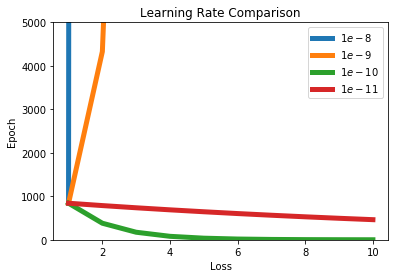

In [33]:
x = np.arange(1,11)

plt.plot(x, loss_value_of_learning_rate_08, lw=5, label="$1e-8$")
plt.plot(x, loss_value_of_learning_rate_09, lw=5, label="$1e-9$")
plt.plot(x, loss_value_of_learning_rate_10, lw=5, label="$1e-10$")
plt.plot(x, loss_value_of_learning_rate_11, lw=5, label="$1e-11$")

plt.ylabel("Epoch")
plt.xlabel("Loss")
plt.title("Learning Rate Comparison")
plt.legend()

plt.ylim(0,5e3)

plt.savefig("learning_rate_Comparison.png",dpi=300,format="png") 
plt.show()

# Optimize the Lambda 

In [37]:
def train_lambda(LAMBDAS, LEANING_RATE=None, EPOCH=None):

    for LAMBDA in LAMBDAS:
        train_epoch(learning_rate=LEANING_RATE, EPOCH=EPOCH, LAMBDA=LAMBDA)

In [40]:
train_lambda(LAMBDAS=[1, 0.5 , 0.1, 0.01, 0], LEANING_RATE=1e-10, EPOCH=10)